<a href="https://colab.research.google.com/github/salim-1234/dissertation/blob/plotting/Dissertation_RF_Fingerprinting_using_kaggle_Many_sig.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import os.path

import scipy,scipy.spatial
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100

from  data_utilities import *
# from definitions import *
# from run_train_eval_net import run_train_eval_net,run_eval_net

In [ ]:
import os
GPU = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=GPU

In [3]:
dataset_name = 'ManySig'
#dataset_path='../../orbit_rf_dataset/data/compact_pkl_datasets/' original paper data path
dataset_path='/content/drive/MyDrive/Colab Notebooks/'

compact_dataset = load_compact_pkl_dataset(dataset_path,dataset_name)



In [19]:
#print some meta information
tx_list = compact_dataset['tx_list']
rx_list = compact_dataset['rx_list']

equalized = 0


n_tx = len(tx_list)
n_rx = len(rx_list)
n_capture_date_list = len(capture_date_list)

capture_date_list = compact_dataset['capture_date_list']
iq_data = compact_dataset['data'][0]  # still list #(2,1000,256,2)
print(n_tx,n_rx,n_capture_date_list)
print(tx_list,rx_list,capture_date_list)

6 12 4
['14-10', '14-7', '20-15', '20-19', '6-15', '8-20'] ['8-8', '2-19', '1-19', '20-1', '14-7', '2-1', '7-7', '18-2', '3-19', '7-14', '19-2', '1-1'] ['2021_03_01', '2021_03_08', '2021_03_15', '2021_03_23']


Here's a visual representation of the WiSig ORBIT testbed grid, showing the positions of:

Transmitters (blue circles)

Receivers (green triangles)

Each label (e.g., 14-10) marks the (row-column) grid coordinate of a node. The ORBIT testbed is a 20×20 wireless grid where transmitters and receivers are placed at different spatial locations. This spatial diversity helps:

Simulate real wireless propagation environments

Evaluate models across different Tx-Rx paths

Study robustness to position and channel variation

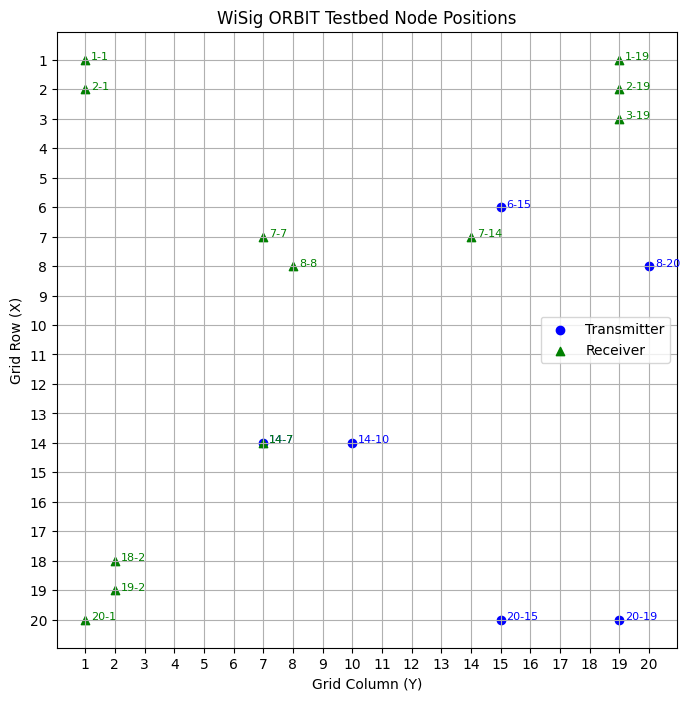

In [20]:
import matplotlib.pyplot as plt

# Example: visualize a simplified ORBIT grid and highlight Tx/Rx node positions
tx_nodes = ['14-10', '14-7', '20-15', '20-19', '6-15', '8-20']
rx_nodes = ['1-1', '1-19', '14-7', '18-2', '19-2', '2-1', '2-19', '20-1', '3-19', '7-14', '7-7', '8-8']

def extract_coordinates(node_list):
    return [(int(n.split('-')[0]), int(n.split('-')[1])) for n in node_list]

tx_coords = extract_coordinates(tx_nodes)
rx_coords = extract_coordinates(rx_nodes)

plt.figure(figsize=(8, 8))
plt.grid(True)
plt.xticks(range(0, 21))
plt.yticks(range(0, 21))
plt.gca().invert_yaxis()

# Plot all nodes
for x, y in tx_coords:
    plt.scatter(y, x, marker='o', color='blue', label='Transmitter' if 'Transmitter' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.text(y+0.2, x, f"{x}-{y}", fontsize=8, color='blue')

for x, y in rx_coords:
    plt.scatter(y, x, marker='^', color='green', label='Receiver' if 'Receiver' not in plt.gca().get_legend_handles_labels()[1] else "")
    plt.text(y+0.2, x, f"{x}-{y}", fontsize=8, color='green')

plt.title("WiSig ORBIT Testbed Node Positions")
plt.xlabel("Grid Column (Y)")
plt.ylabel("Grid Row (X)")
plt.legend()
plt.show()


In [21]:
first_entry = compact_dataset['data'][0]
print(type(first_entry))         # Should be list
print(len(first_entry))          # Should be 1000 (number of packets)
print(type(first_entry[0]))      # Should be ndarray (each packet)
print(np.array(first_entry).shape)  # Should give full shape: (1000, 256, 2)


<class 'list'>
12
<class 'list'>
(12, 4, 2, 1000, 256, 2)


In [24]:
# Extract one sample
iq_data = compact_dataset['data'][0]  # still list #(2,1000,256,2)
print(type(iq_data))  # should be list
print(iq_data)


<class 'list'>
[[[array([[[-3.05183457e-05,  6.65299920e-03],
        [-1.26651134e-02, -2.34991265e-03],
        [ 5.79848594e-04, -1.05898660e-02],
        ...,
        [-2.47198599e-03,  8.39254539e-03],
        [ 7.62958662e-04,  6.22574240e-03],
        [-3.08235292e-03, -4.66930680e-03]],

       [[ 2.99079786e-03,  2.83820624e-03],
        [-6.89714635e-03,  4.42516012e-03],
        [-9.52172372e-03, -9.06394888e-03],
        ...,
        [-6.98870094e-03,  4.33360506e-03],
        [-1.52591732e-04,  9.30809509e-03],
        [-2.31939438e-03,  9.15550394e-04]],

       [[ 6.22574240e-03, -3.44857317e-03],
        [ 8.14839825e-03,  1.11697149e-02],
        [-1.01320911e-02,  5.09656360e-03],
        ...,
        [ 6.83610933e-03, -5.55433892e-03],
        [ 3.29598133e-03, -3.20442626e-03],
        [-1.64799066e-03,  5.67641249e-03]],

       ...,

       [[ 3.63168307e-03, -1.33365169e-02],
        [ 1.06814206e-02,  4.51671518e-03],
        [-2.13628417e-04,  1.55948745e-02],


In [12]:
import numpy as np

iq_data = compact_dataset['data'][0]

# Convert list to numpy array
iq_data_array = np.array(iq_data)

# Now extract I and Q components
i_samples = iq_data_array[:, 0]
q_samples = iq_data_array[:, 1]


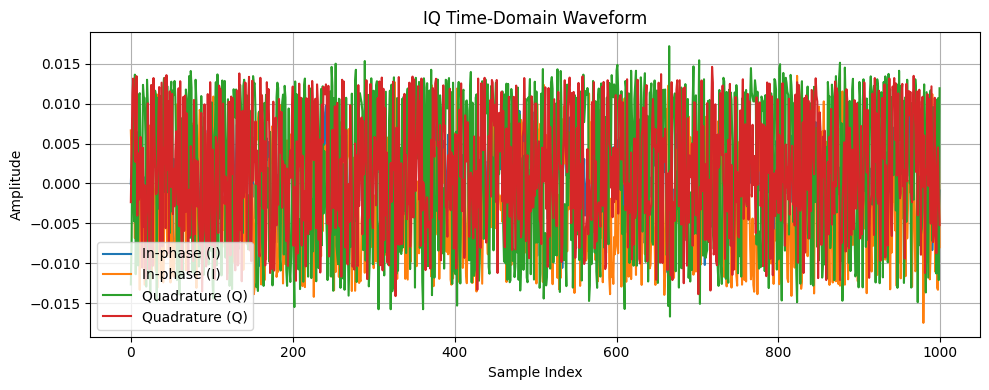

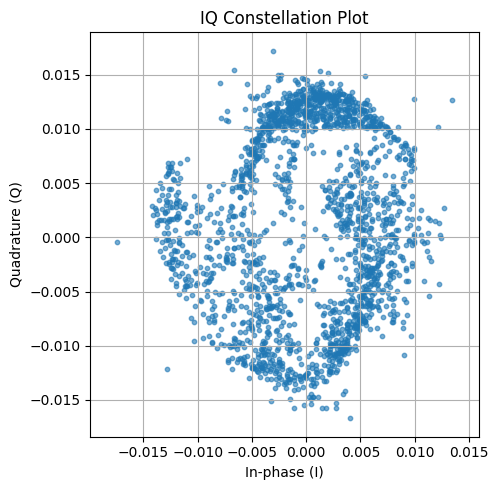

In [26]:
# Convert to NumPy array for processing
data_np = np.array(compact_dataset['data'])  # shape: (12, 4, 2, 1000, 256, 2)

# Select one sample: Rx=0, Day=0, Tx=0, Packet=0
iq_sample = data_np[0, 0, 0, 0]  # shape (256, 2)

# Plot Time-Domain IQ
plt.figure(figsize=(10, 4))
plt.plot(iq_sample[:, 0], label='In-phase (I)')
plt.plot(iq_sample[:, 1], label='Quadrature (Q)')
plt.title("IQ Time-Domain Waveform")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot IQ Constellation
plt.figure(figsize=(5, 5))
plt.scatter(iq_sample[:, 0], iq_sample[:, 1], s=10, alpha=0.6)
plt.title("IQ Constellation Plot")
plt.xlabel("In-phase (I)")
plt.ylabel("Quadrature (Q)")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()

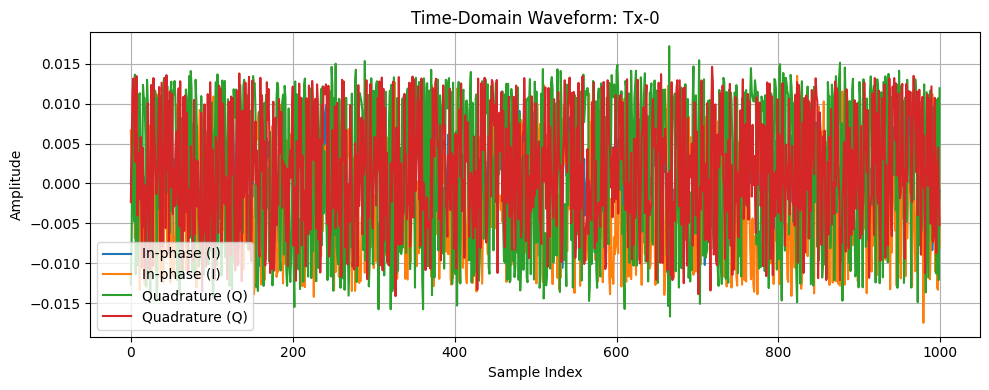

In [34]:
data = np.array(compact_dataset['data'])  # shape: (12, 4, 2, 1000, 256, 2)

# Choose one Rx, one Day, one Tx (0 to 5), and one Packet
rx_idx = 0
day_idx = 0
tx_idx = 0  # Transmitter index 0
pkt_idx = 0

iq_sample = data[rx_idx, day_idx, tx_idx, pkt_idx]  # shape: (256, 2)

# Plot I and Q
plt.figure(figsize=(10, 4))
plt.plot(iq_sample[:, 0], label='In-phase (I)')
plt.plot(iq_sample[:, 1], label='Quadrature (Q)')
plt.title(f"Time-Domain Waveform: Tx-{tx_idx}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



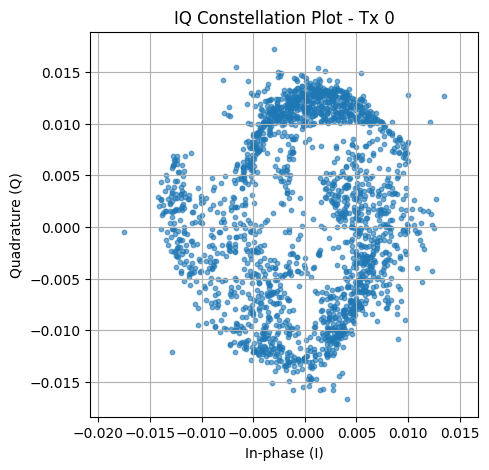

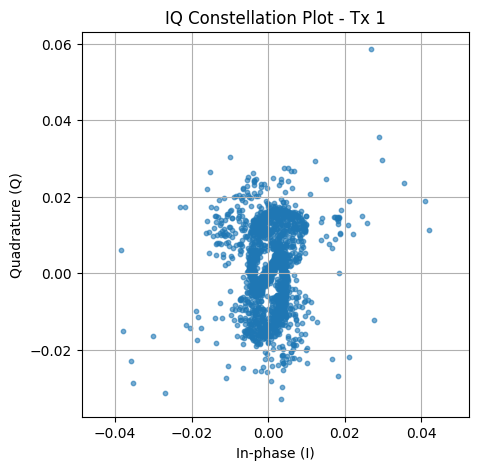

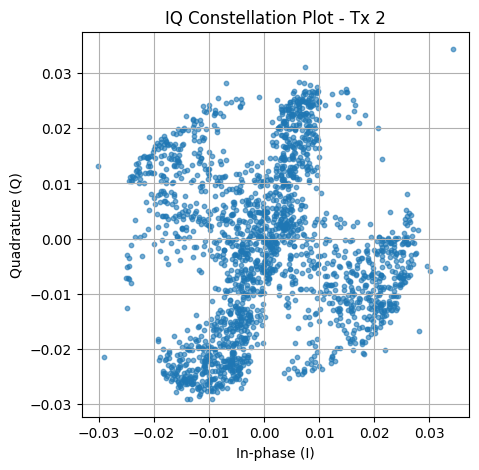

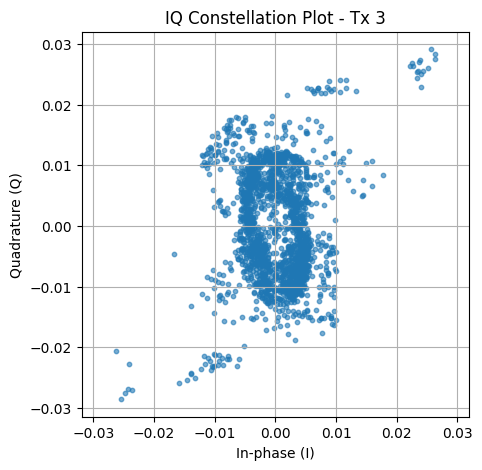

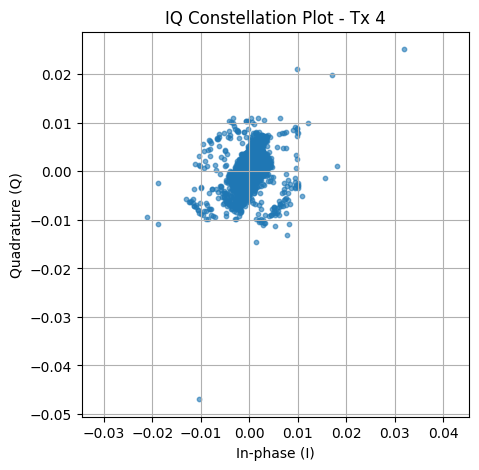

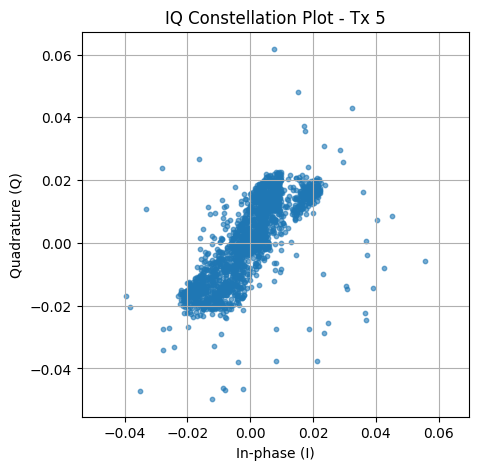

In [31]:
# Convert list to numpy array first if not already done
data_np = np.array(data)

# Loop through all 6 transmitters
for tx in range(6):
    iq_sample = data_np[tx][0][0][0]  # Tx-tx, Rx-0, Day-0, Packet-0
    plt.figure(figsize=(5, 5))
    plt.scatter(iq_sample[:, 0], iq_sample[:, 1], s=10, alpha=0.6)
    plt.title(f"IQ Constellation Plot - Tx {tx}")
    plt.xlabel("In-phase (I)")
    plt.ylabel("Quadrature (Q)")
    plt.grid(True)
    plt.axis('equal')
    plt.show()

In [17]:
#original paper
np.random.seed(0)
n_real = 5
rx_list_real = []
for i in range(n_real):
    np.random.shuffle(rx_list)
    rx_list_real.append(np.copy(rx_list).tolist())
print(rx_list_real)

[['19-2', '2-19', '18-2', '14-7', '2-1', '7-7', '1-1', '8-8', '20-1', '3-19', '1-19', '7-14'], ['7-7', '18-2', '14-7', '2-1', '3-19', '19-2', '7-14', '8-8', '1-1', '2-19', '1-19', '20-1'], ['7-14', '18-2', '1-19', '14-7', '8-8', '19-2', '20-1', '7-7', '2-1', '3-19', '2-19', '1-1'], ['1-19', '8-8', '2-1', '3-19', '19-2', '20-1', '18-2', '7-14', '7-7', '2-19', '1-1', '14-7'], ['8-8', '2-19', '1-19', '20-1', '14-7', '2-1', '7-7', '18-2', '3-19', '7-14', '19-2', '1-1']]


In [13]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K


In [14]:
 def create_net():

    inputs = Input(shape=(256,2))
    x = Reshape((256,2,1))(inputs)
    x = Conv2D(8,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,2),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,2))(x)
    x = Conv2D(32,(3,1),activation='relu',padding = 'same')(x)
    x = MaxPool2D((2,1))(x)
    x = Conv2D(16,(3,1),activation='relu',padding = 'same')(x)
    #x = resnet(x,64,(3,2),'6')
    #x = MaxPool2D((2,2))(x)
    x = Flatten()(x)



    x = Dense(100, activation='relu', kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    # x = Dropout(0.3)(x)
    x = Dense(80, activation='relu',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    x = Dropout(0.5)(x)
    x = Dense(n_tx, activation='softmax',kernel_regularizer = keras.regularizers.l2(0.0001))(x)
    ops = x

    classifier = Model(inputs,ops)
    classifier.compile(loss='categorical_crossentropy',metrics=['categorical_accuracy'],optimizer=keras.optimizers.Adam(0.0005))

    return classifier

classifier = create_net()
classifier.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 2, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 2, 8)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 2, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 2, 16)     │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 2, 16)      │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 1, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 1, 32)      │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 1, 16)      │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           486 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,778 (155.38 KB)

 Trainable params: 39,778 (155.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def evaluate_test(classifier):
    pred = classifier.predict(sig_dfTest)
    acc = np.mean(np.argmax(pred,1)==txidNum_dfTest)

    test_indx = ()
    for indx in range(len(tx_list)):
        cls_indx = np.where(txidNum_dfTest == indx)
        test_indx = test_indx + (cls_indx[0][:n_test_samples],)
    test_indx = np.concatenate(test_indx)
    acc_bal = np.mean(np.argmax(pred[test_indx,:],1)==txidNum_dfTest[test_indx])
    return acc,acc_bal

In [ ]:
TRAIN = True
continue_training = True
nreal = 5

real_list = list(range(nreal))

sig_len_list = [5, 10, 25, 50, 100, 400, 800]
print(sig_len_list)

patience = 5
n_epochs = 100






smTest_results_real = []
dfTest_results_real = []
dfTestBal_results_real = []

for sig_len in sig_len_list:
    print("");print("")
    print("sig_len: {}  ".format(sig_len))
    fname_w = 'weights/d004_{:04d}.weights.hd5'.format(sig_len)
    rx_train_list= rx_list

    dataset = merge_compact_dataset(compact_dataset,capture_date_list,tx_list,rx_train_list, max_sig = sig_len+200,equalized=equalized)

    val_frac = 100/(sig_len+200)
    test_frac = 100/(sig_len+200)

    train_augset,val_augset,test_augset_smRx =  prepare_dataset(dataset,tx_list,
                                                        val_frac=val_frac, test_frac=test_frac)
    [sig_train,txidNum_train,txid_train,cls_weights] = train_augset
    [sig_valid,txidNum_valid,txid_valid,_] = val_augset
    [sig_smTest,txidNum_smTest,txid_smTest,cls_weights] = test_augset_smRx

    if continue_training:
        skip = os.path.isfile(fname_w)
    else:
        skip = False
    classifier = create_net()
    if TRAIN and not skip:
        filepath = 't_weights_'+GPU+'weights.h5' #updated to valid weights format
        c=[ keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True),
          keras.callbacks.EarlyStopping(monitor='val_loss',  patience=patience)]
        cls_weights_dict = {i: w for i, w in enumerate(cls_weights)}##converted list into dictionary

        history = classifier.fit(sig_train,txid_train,class_weight=cls_weights_dict,
                                 validation_data=(sig_valid , txid_valid),callbacks=c, epochs=n_epochs)
        classifier.load_weights(filepath)
        classifier.save_weights(fname_w)

    else:
        classifier.load_weights(fname_w)

    smTest_r = classifier.evaluate(sig_smTest,txid_smTest,verbose=0)[1]


    print(smTest_r)
    smTest_results_real.append(smTest_r)
    K.clear_session()





[5, 10, 25, 50, 100, 400, 800]


sig_len: 5  
Epoch 1/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.1714 - loss: 1.8283
Epoch 1: val_loss improved from inf to 1.80458, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 272ms/step - categorical_accuracy: 0.1717 - loss: 1.8281 - val_categorical_accuracy: 0.2472 - val_loss: 1.8046
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.2334 - loss: 1.8090
Epoch 2: val_loss improved from 1.80458 to 1.76750, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 259ms/step - categorical_accuracy: 0.2336 - loss: 1.8089 - val_categorical_accuracy: 0.3669 - val_loss: 1.7675
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.3056 - loss: 1.7413
Epoch 3: val_loss improved from 1.76750 to 1.55313, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - categorical_accuracy: 0.3060 - loss: 1.7402 - val_categorical_accuracy: 0.3660 - val_loss: 1.5531
Epoch 4/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.3795 - loss: 1.4961
Epoch 4: val_loss improved from 1.55313 to 1.38077, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - categorical_accuracy: 0.3807 - loss: 1.4936 - val_categorical_accuracy: 0.4303 - val_loss: 1.3808
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.4668 - loss: 1.3462
Epoch 5: val_loss improved from 1.38077 to 1.22556, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - categorical_accuracy: 0.4669 - loss: 1.3452 - val_categorical_accuracy: 0.5176 - val_loss: 1.2256
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.5174 - loss: 1.1951
Epoch 6: val_loss improved from 1.22556 to 1.13860, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - categorical_accuracy: 0.5177 - loss: 1.1948 - val_categorical_accuracy: 0.5556 - val_loss: 1.1386
Epoch 7/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5315 - loss: 1.1886
Epoch 7: val_loss improved from 1.13860 to 1.08728, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - categorical_accuracy: 0.5323 - loss: 1.1867 - val_categorical_accuracy: 0.5368 - val_loss: 1.0873
Epoch 8/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.5691 - loss: 1.0682
Epoch 8: val_loss improved from 1.08728 to 1.03687, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 259ms/step - categorical_accuracy: 0.5700 - loss: 1.0677 - val_categorical_accuracy: 0.5986 - val_loss: 1.0369
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5851 - loss: 0.9986
Epoch 9: val_loss improved from 1.03687 to 1.03060, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - categorical_accuracy: 0.5852 - loss: 0.9985 - val_categorical_accuracy: 0.6100 - val_loss: 1.0306
Epoch 10/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6187 - loss: 0.9626
Epoch 10: val_loss improved from 1.03060 to 1.01774, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - categorical_accuracy: 0.6186 - loss: 0.9629 - val_categorical_accuracy: 0.6194 - val_loss: 1.0177
Epoch 11/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6437 - loss: 0.8986
Epoch 11: val_loss improved from 1.01774 to 0.96545, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - categorical_accuracy: 0.6435 - loss: 0.8986 - val_categorical_accuracy: 0.6250 - val_loss: 0.9654
Epoch 12/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6552 - loss: 0.9130
Epoch 12: val_loss improved from 0.96545 to 0.95859, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - categorical_accuracy: 0.6552 - loss: 0.9126 - val_categorical_accuracy: 0.6398 - val_loss: 0.9586
Epoch 13/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.6720 - loss: 0.8391
Epoch 13: val_loss improved from 0.95859 to 0.93055, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - categorical_accuracy: 0.6722 - loss: 0.8392 - val_categorical_accuracy: 0.6594 - val_loss: 0.9305
Epoch 14/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6832 - loss: 0.8505
Epoch 14: val_loss did not improve from 0.93055
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - categorical_accuracy: 0.6831 - loss: 0.8499 - val_categorical_accuracy: 0.6534 - val_loss: 0.9385
Epoch 15/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.7084 - loss: 0.7827
Epoch 15: val_loss improved from 0.93055 to 0.90535, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - categorical_accuracy: 0.7078 - loss: 0.7832 - val_categorical_accuracy: 0.6726 - val_loss: 0.9054
Epoch 16/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.7136 - loss: 0.7681
Epoch 16: val_loss did not improve from 0.90535
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - categorical_accuracy: 0.7136 - loss: 0.7679 - val_categorical_accuracy: 0.6665 - val_loss: 0.9184
Epoch 17/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.7564 - loss: 0.7309
Epoch 17: val_loss did not improve from 0.90535
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - categorical_accuracy: 0.7559 - loss: 0.7307 - val_categorical_accuracy: 0.6747 - val_loss: 0.9140
Epoch 18/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.7576 - loss: 0.6851
Epoch 18: val_loss did not improve from 0.90535
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 247ms/step - categorical_accuracy: 0.7571 - loss: 0.6859 - val_categorical_accuracy: 0.6698 - val_loss: 

45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - categorical_accuracy: 0.7714 - loss: 0.6640 - val_categorical_accuracy: 0.6844 - val_loss: 0.8889
Epoch 20/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.7609 - loss: 0.6596
Epoch 20: val_loss did not improve from 0.88893
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - categorical_accuracy: 0.7613 - loss: 0.6590 - val_categorical_accuracy: 0.6755 - val_loss: 0.9039
Epoch 21/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.7807 - loss: 0.6110
Epoch 21: val_loss improved from 0.88893 to 0.88262, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - categorical_accuracy: 0.7808 - loss: 0.6112 - val_categorical_accuracy: 0.6934 - val_loss: 0.8826
Epoch 22/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8008 - loss: 0.5865
Epoch 22: val_loss improved from 0.88262 to 0.88204, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - categorical_accuracy: 0.8004 - loss: 0.5870 - val_categorical_accuracy: 0.7006 - val_loss: 0.8820
Epoch 23/100
43/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8074 - loss: 0.5643
Epoch 23: val_loss improved from 0.88204 to 0.86034, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - categorical_accuracy: 0.8064 - loss: 0.5652 - val_categorical_accuracy: 0.7066 - val_loss: 0.8603
Epoch 24/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8034 - loss: 0.5701
Epoch 24: val_loss did not improve from 0.86034
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - categorical_accuracy: 0.8036 - loss: 0.5697 - val_categorical_accuracy: 0.7064 - val_loss: 0.8688
Epoch 25/100
42/45 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.8220 - loss: 0.5350
Epoch 25: val_loss did not improve from 0.86034
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - categorical_accuracy: 0.8205 - loss: 0.5370 - val_categorical_accuracy: 0.7062 - val_loss: 0.8823
Epoch 26/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.8207 - loss: 0.4978
Epoch 26: val_loss did not improve from 0.86034
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - categorical_accuracy: 0.8209 - loss: 0.4982 - val_categorical_accuracy: 0.7115 - val_loss: 

45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - categorical_accuracy: 0.8269 - loss: 0.4702 - val_categorical_accuracy: 0.7325 - val_loss: 0.8561
Epoch 29/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8804 - loss: 0.4083
Epoch 29: val_loss improved from 0.85611 to 0.83793, saving model to t_weights_0.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - categorical_accuracy: 0.8796 - loss: 0.4093 - val_categorical_accuracy: 0.7306 - val_loss: 0.8379
Epoch 30/100
44/45 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.8715 - loss: 0.3786
Epoch 30: val_loss did not improve from 0.83793
45/45 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - categorical_accuracy: 0.8713 - loss: 0.3794 - val_categorical_accuracy: 0.7357 - val_loss: 0.8660
Epoch 31/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8741 - loss: 0.3610
Epoch 31: val_loss did not improve from 0.83793
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - categorical_accuracy: 0.8740 - loss: 0.3616 - val_categorical_accuracy: 0.7278 - val_loss: 0.8723
Epoch 32/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8972 - loss: 0.3467
Epoch 32: val_loss did not improve from 0.83793
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - categorical_accuracy: 0.8969 - loss: 0.3473 - val_categorical_accuracy: 0.7309 - val_loss: 

90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - categorical_accuracy: 0.1730 - loss: 1.8254 - val_categorical_accuracy: 0.2190 - val_loss: 1.7927
Epoch 2/100
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.2801 - loss: 1.7694
Epoch 2: val_loss improved from 1.79268 to 1.49233, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - categorical_accuracy: 0.2809 - loss: 1.7680 - val_categorical_accuracy: 0.4040 - val_loss: 1.4923
Epoch 3/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.4243 - loss: 1.4242
Epoch 3: val_loss improved from 1.49233 to 1.18513, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - categorical_accuracy: 0.4252 - loss: 1.4216 - val_categorical_accuracy: 0.5365 - val_loss: 1.1851
Epoch 4/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5146 - loss: 1.1844
Epoch 4: val_loss improved from 1.18513 to 1.05835, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - categorical_accuracy: 0.5150 - loss: 1.1837 - val_categorical_accuracy: 0.6052 - val_loss: 1.0584
Epoch 5/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6175 - loss: 1.0279
Epoch 5: val_loss improved from 1.05835 to 0.98756, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - categorical_accuracy: 0.6169 - loss: 1.0284 - val_categorical_accuracy: 0.6223 - val_loss: 0.9876
Epoch 6/100
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.6165 - loss: 0.9716
Epoch 6: val_loss improved from 0.98756 to 0.95112, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - categorical_accuracy: 0.6166 - loss: 0.9716 - val_categorical_accuracy: 0.6334 - val_loss: 0.9511
Epoch 7/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.6462 - loss: 0.9407
Epoch 7: val_loss improved from 0.95112 to 0.89741, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 81ms/step - categorical_accuracy: 0.6462 - loss: 0.9405 - val_categorical_accuracy: 0.6712 - val_loss: 0.8974
Epoch 8/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6696 - loss: 0.8641
Epoch 8: val_loss improved from 0.89741 to 0.83928, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - categorical_accuracy: 0.6697 - loss: 0.8640 - val_categorical_accuracy: 0.6870 - val_loss: 0.8393
Epoch 9/100
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6832 - loss: 0.8381
Epoch 9: val_loss did not improve from 0.83928
90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - categorical_accuracy: 0.6830 - loss: 0.8381 - val_categorical_accuracy: 0.6830 - val_loss: 0.8535
Epoch 10/100
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.6996 - loss: 0.7999
Epoch 10: val_loss improved from 0.83928 to 0.79682, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - categorical_accuracy: 0.6997 - loss: 0.7994 - val_categorical_accuracy: 0.7101 - val_loss: 0.7968
Epoch 11/100
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.7261 - loss: 0.7353
Epoch 11: val_loss improved from 0.79682 to 0.78222, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - categorical_accuracy: 0.7260 - loss: 0.7353 - val_categorical_accuracy: 0.7149 - val_loss: 0.7822
Epoch 12/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.7288 - loss: 0.7233
Epoch 12: val_loss improved from 0.78222 to 0.73663, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - categorical_accuracy: 0.7291 - loss: 0.7226 - val_categorical_accuracy: 0.7277 - val_loss: 0.7366
Epoch 13/100
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.7615 - loss: 0.6519
Epoch 13: val_loss improved from 0.73663 to 0.72882, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - categorical_accuracy: 0.7616 - loss: 0.6522 - val_categorical_accuracy: 0.7315 - val_loss: 0.7288
Epoch 14/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.7569 - loss: 0.6663
Epoch 14: val_loss improved from 0.72882 to 0.68177, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - categorical_accuracy: 0.7574 - loss: 0.6652 - val_categorical_accuracy: 0.7572 - val_loss: 0.6818
Epoch 15/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.7866 - loss: 0.5978
Epoch 15: val_loss improved from 0.68177 to 0.66314, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - categorical_accuracy: 0.7866 - loss: 0.5979 - val_categorical_accuracy: 0.7650 - val_loss: 0.6631
Epoch 16/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8002 - loss: 0.5542
Epoch 16: val_loss improved from 0.66314 to 0.63733, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - categorical_accuracy: 0.8002 - loss: 0.5543 - val_categorical_accuracy: 0.7796 - val_loss: 0.6373
Epoch 17/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8258 - loss: 0.5138
Epoch 17: val_loss improved from 0.63733 to 0.62194, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - categorical_accuracy: 0.8256 - loss: 0.5141 - val_categorical_accuracy: 0.7803 - val_loss: 0.6219
Epoch 18/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8306 - loss: 0.4860
Epoch 18: val_loss did not improve from 0.62194
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - categorical_accuracy: 0.8306 - loss: 0.4861 - val_categorical_accuracy: 0.7766 - val_loss: 0.6328
Epoch 19/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8490 - loss: 0.4462
Epoch 19: val_loss improved from 0.62194 to 0.60197, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - categorical_accuracy: 0.8488 - loss: 0.4467 - val_categorical_accuracy: 0.7887 - val_loss: 0.6020
Epoch 20/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8396 - loss: 0.4474
Epoch 20: val_loss improved from 0.60197 to 0.59882, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - categorical_accuracy: 0.8395 - loss: 0.4474 - val_categorical_accuracy: 0.7992 - val_loss: 0.5988
Epoch 21/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8635 - loss: 0.4151
Epoch 21: val_loss improved from 0.59882 to 0.59174, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - categorical_accuracy: 0.8634 - loss: 0.4152 - val_categorical_accuracy: 0.8070 - val_loss: 0.5917
Epoch 22/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.8780 - loss: 0.3712
Epoch 22: val_loss did not improve from 0.59174
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - categorical_accuracy: 0.8779 - loss: 0.3714 - val_categorical_accuracy: 0.8002 - val_loss: 0.6138
Epoch 23/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8693 - loss: 0.3806
Epoch 23: val_loss improved from 0.59174 to 0.55978, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - categorical_accuracy: 0.8695 - loss: 0.3805 - val_categorical_accuracy: 0.8249 - val_loss: 0.5598
Epoch 24/100
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.8905 - loss: 0.3371
Epoch 24: val_loss did not improve from 0.55978
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - categorical_accuracy: 0.8905 - loss: 0.3372 - val_categorical_accuracy: 0.8218 - val_loss: 0.5655
Epoch 25/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9055 - loss: 0.3216
Epoch 25: val_loss did not improve from 0.55978
90/90 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - categorical_accuracy: 0.9054 - loss: 0.3216 - val_categorical_accuracy: 0.8034 - val_loss: 0.6077
Epoch 26/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9069 - loss: 0.2848
Epoch 26: val_loss improved from 0.55978 to 0.53724, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - categorical_accuracy: 0.9066 - loss: 0.2856 - val_categorical_accuracy: 0.8318 - val_loss: 0.5372
Epoch 27/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9198 - loss: 0.2826
Epoch 27: val_loss improved from 0.53724 to 0.53278, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - categorical_accuracy: 0.9199 - loss: 0.2823 - val_categorical_accuracy: 0.8392 - val_loss: 0.5328
Epoch 28/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.9240 - loss: 0.2588
Epoch 28: val_loss did not improve from 0.53278
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - categorical_accuracy: 0.9239 - loss: 0.2589 - val_categorical_accuracy: 0.8406 - val_loss: 0.5349
Epoch 29/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9204 - loss: 0.2386
Epoch 29: val_loss improved from 0.53278 to 0.51222, saving model to t_weights_0.h5


90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - categorical_accuracy: 0.9202 - loss: 0.2391 - val_categorical_accuracy: 0.8442 - val_loss: 0.5122
Epoch 30/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.9300 - loss: 0.2285
Epoch 30: val_loss did not improve from 0.51222
90/90 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - categorical_accuracy: 0.9299 - loss: 0.2287 - val_categorical_accuracy: 0.8458 - val_loss: 0.5559
Epoch 31/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9373 - loss: 0.2232
Epoch 31: val_loss did not improve from 0.51222
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - categorical_accuracy: 0.9370 - loss: 0.2235 - val_categorical_accuracy: 0.8516 - val_loss: 0.5324
Epoch 32/100
88/90 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9403 - loss: 0.1951
Epoch 32: val_loss did not improve from 0.51222
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - categorical_accuracy: 0.9401 - loss: 0.1954 - val_categorical_accuracy: 0.8395 - val_loss: 0.5

225/225 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - categorical_accuracy: 0.2099 - loss: 1.8038 - val_categorical_accuracy: 0.5053 - val_loss: 1.2153
Epoch 2/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.5198 - loss: 1.2040
Epoch 2: val_loss improved from 1.21533 to 0.94525, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - categorical_accuracy: 0.5199 - loss: 1.2037 - val_categorical_accuracy: 0.6502 - val_loss: 0.9453
Epoch 3/100
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6346 - loss: 0.9827
Epoch 3: val_loss improved from 0.94525 to 0.78218, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - categorical_accuracy: 0.6347 - loss: 0.9820 - val_categorical_accuracy: 0.7194 - val_loss: 0.7822
Epoch 4/100
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6843 - loss: 0.8461
Epoch 4: val_loss improved from 0.78218 to 0.69591, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - categorical_accuracy: 0.6845 - loss: 0.8458 - val_categorical_accuracy: 0.7508 - val_loss: 0.6959
Epoch 5/100
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.7422 - loss: 0.7301
Epoch 5: val_loss improved from 0.69591 to 0.55380, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - categorical_accuracy: 0.7424 - loss: 0.7298 - val_categorical_accuracy: 0.8178 - val_loss: 0.5538
Epoch 6/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8012 - loss: 0.6054
Epoch 6: val_loss improved from 0.55380 to 0.48494, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - categorical_accuracy: 0.8012 - loss: 0.6054 - val_categorical_accuracy: 0.8611 - val_loss: 0.4849
Epoch 7/100
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8390 - loss: 0.5271
Epoch 7: val_loss improved from 0.48494 to 0.44950, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - categorical_accuracy: 0.8389 - loss: 0.5270 - val_categorical_accuracy: 0.8538 - val_loss: 0.4495
Epoch 8/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8568 - loss: 0.4610
Epoch 8: val_loss improved from 0.44950 to 0.38593, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - categorical_accuracy: 0.8568 - loss: 0.4609 - val_categorical_accuracy: 0.8867 - val_loss: 0.3859
Epoch 9/100
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8807 - loss: 0.3959
Epoch 9: val_loss improved from 0.38593 to 0.35223, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - categorical_accuracy: 0.8807 - loss: 0.3960 - val_categorical_accuracy: 0.8977 - val_loss: 0.3522
Epoch 10/100
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8873 - loss: 0.3654
Epoch 10: val_loss improved from 0.35223 to 0.32923, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - categorical_accuracy: 0.8875 - loss: 0.3653 - val_categorical_accuracy: 0.9069 - val_loss: 0.3292
Epoch 11/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9050 - loss: 0.3324
Epoch 11: val_loss improved from 0.32923 to 0.32016, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - categorical_accuracy: 0.9050 - loss: 0.3324 - val_categorical_accuracy: 0.9118 - val_loss: 0.3202
Epoch 12/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9198 - loss: 0.2847
Epoch 12: val_loss improved from 0.32016 to 0.28379, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step - categorical_accuracy: 0.9198 - loss: 0.2847 - val_categorical_accuracy: 0.9250 - val_loss: 0.2838
Epoch 13/100
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9208 - loss: 0.2815
Epoch 13: val_loss did not improve from 0.28379
225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - categorical_accuracy: 0.9209 - loss: 0.2811 - val_categorical_accuracy: 0.9191 - val_loss: 0.2871
Epoch 14/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9364 - loss: 0.2513
Epoch 14: val_loss improved from 0.28379 to 0.26502, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - categorical_accuracy: 0.9364 - loss: 0.2512 - val_categorical_accuracy: 0.9280 - val_loss: 0.2650
Epoch 15/100
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9396 - loss: 0.2192
Epoch 15: val_loss improved from 0.26502 to 0.25627, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - categorical_accuracy: 0.9396 - loss: 0.2192 - val_categorical_accuracy: 0.9326 - val_loss: 0.2563
Epoch 16/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.9469 - loss: 0.2033
Epoch 16: val_loss did not improve from 0.25627
225/225 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - categorical_accuracy: 0.9469 - loss: 0.2033 - val_categorical_accuracy: 0.9298 - val_loss: 0.2680
Epoch 17/100
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9472 - loss: 0.1934
Epoch 17: val_loss did not improve from 0.25627
225/225 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - categorical_accuracy: 0.9472 - loss: 0.1933 - val_categorical_accuracy: 0.9320 - val_loss: 0.2635
Epoch 18/100
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9544 - loss: 0.1718
Epoch 18: val_loss improved from 0.25627 to 0.24735, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - categorical_accuracy: 0.9543 - loss: 0.1718 - val_categorical_accuracy: 0.9334 - val_loss: 0.2473
Epoch 19/100
224/225 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9553 - loss: 0.1683
Epoch 19: val_loss did not improve from 0.24735
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - categorical_accuracy: 0.9553 - loss: 0.1683 - val_categorical_accuracy: 0.9314 - val_loss: 0.2712
Epoch 20/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9593 - loss: 0.1509
Epoch 20: val_loss improved from 0.24735 to 0.22628, saving model to t_weights_0.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - categorical_accuracy: 0.9593 - loss: 0.1509 - val_categorical_accuracy: 0.9400 - val_loss: 0.2263
Epoch 21/100
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9640 - loss: 0.1408
Epoch 21: val_loss did not improve from 0.22628
225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 40ms/step - categorical_accuracy: 0.9640 - loss: 0.1408 - val_categorical_accuracy: 0.9377 - val_loss: 0.2386
Epoch 22/100
223/225 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9701 - loss: 0.1220
Epoch 22: val_loss did not improve from 0.22628
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - categorical_accuracy: 0.9701 - loss: 0.1220 - val_categorical_accuracy: 0.9387 - val_loss: 0.2408
Epoch 23/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9671 - loss: 0.1237
Epoch 23: val_loss did not improve from 0.22628
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - categorical_accuracy: 0.9671 - loss: 0.1238 - val_categorical_accuracy: 0.9465 -

225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - categorical_accuracy: 0.9707 - loss: 0.1132 - val_categorical_accuracy: 0.9452 - val_loss: 0.2219
Epoch 25/100
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.9740 - loss: 0.1075
Epoch 25: val_loss did not improve from 0.22193
225/225 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - categorical_accuracy: 0.9740 - loss: 0.1075 - val_categorical_accuracy: 0.9452 - val_loss: 0.2358
Epoch 26/100
222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.9729 - loss: 0.1040
Epoch 26: val_loss did not improve from 0.22193
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - categorical_accuracy: 0.9729 - loss: 0.1040 - val_categorical_accuracy: 0.9333 - val_loss: 0.2656
Epoch 27/100
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.9733 - loss: 0.1005
Epoch 27: val_loss did not improve from 0.22193
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - categorical_accuracy: 0.9733 - loss: 0.1006 - val_categorical_accuracy: 0.9486 -

450/450 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - categorical_accuracy: 0.2667 - loss: 1.7026 - val_categorical_accuracy: 0.6234 - val_loss: 0.9803
Epoch 2/100
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.6008 - loss: 1.0055
Epoch 2: val_loss improved from 0.98026 to 0.80068, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - categorical_accuracy: 0.6010 - loss: 1.0052 - val_categorical_accuracy: 0.6713 - val_loss: 0.8007
Epoch 3/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.7109 - loss: 0.7942
Epoch 3: val_loss improved from 0.80068 to 0.61079, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - categorical_accuracy: 0.7109 - loss: 0.7941 - val_categorical_accuracy: 0.7862 - val_loss: 0.6108
Epoch 4/100
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.7819 - loss: 0.6319
Epoch 4: val_loss improved from 0.61079 to 0.48855, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - categorical_accuracy: 0.7820 - loss: 0.6317 - val_categorical_accuracy: 0.8375 - val_loss: 0.4885
Epoch 5/100
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.8434 - loss: 0.4880
Epoch 5: val_loss improved from 0.48855 to 0.41144, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 41ms/step - categorical_accuracy: 0.8434 - loss: 0.4879 - val_categorical_accuracy: 0.8713 - val_loss: 0.4114
Epoch 6/100
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.8730 - loss: 0.4184
Epoch 6: val_loss improved from 0.41144 to 0.33179, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - categorical_accuracy: 0.8730 - loss: 0.4183 - val_categorical_accuracy: 0.9001 - val_loss: 0.3318
Epoch 7/100
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8984 - loss: 0.3417
Epoch 7: val_loss improved from 0.33179 to 0.30100, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 24s 37ms/step - categorical_accuracy: 0.8985 - loss: 0.3416 - val_categorical_accuracy: 0.9075 - val_loss: 0.3010
Epoch 8/100
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9164 - loss: 0.2953
Epoch 8: val_loss improved from 0.30100 to 0.26305, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - categorical_accuracy: 0.9164 - loss: 0.2953 - val_categorical_accuracy: 0.9222 - val_loss: 0.2630
Epoch 9/100
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9300 - loss: 0.2541
Epoch 9: val_loss improved from 0.26305 to 0.22867, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - categorical_accuracy: 0.9300 - loss: 0.2541 - val_categorical_accuracy: 0.9342 - val_loss: 0.2287
Epoch 10/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.9365 - loss: 0.2272
Epoch 10: val_loss did not improve from 0.22867
450/450 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - categorical_accuracy: 0.9365 - loss: 0.2272 - val_categorical_accuracy: 0.9325 - val_loss: 0.2379
Epoch 11/100
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - categorical_accuracy: 0.9470 - loss: 0.1953
Epoch 11: val_loss improved from 0.22867 to 0.21132, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - categorical_accuracy: 0.9470 - loss: 0.1952 - val_categorical_accuracy: 0.9405 - val_loss: 0.2113
Epoch 12/100
447/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9542 - loss: 0.1673
Epoch 12: val_loss improved from 0.21132 to 0.21041, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - categorical_accuracy: 0.9542 - loss: 0.1673 - val_categorical_accuracy: 0.9385 - val_loss: 0.2104
Epoch 13/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.9517 - loss: 0.1690
Epoch 13: val_loss improved from 0.21041 to 0.20485, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - categorical_accuracy: 0.9517 - loss: 0.1690 - val_categorical_accuracy: 0.9455 - val_loss: 0.2049
Epoch 14/100
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9640 - loss: 0.1395
Epoch 14: val_loss improved from 0.20485 to 0.19351, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - categorical_accuracy: 0.9640 - loss: 0.1395 - val_categorical_accuracy: 0.9467 - val_loss: 0.1935
Epoch 15/100
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9646 - loss: 0.1310
Epoch 15: val_loss did not improve from 0.19351
450/450 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - categorical_accuracy: 0.9646 - loss: 0.1310 - val_categorical_accuracy: 0.9471 - val_loss: 0.1971
Epoch 16/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9683 - loss: 0.1141
Epoch 16: val_loss improved from 0.19351 to 0.19289, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - categorical_accuracy: 0.9683 - loss: 0.1141 - val_categorical_accuracy: 0.9495 - val_loss: 0.1929
Epoch 17/100
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9701 - loss: 0.1112
Epoch 17: val_loss did not improve from 0.19289
450/450 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - categorical_accuracy: 0.9701 - loss: 0.1112 - val_categorical_accuracy: 0.9488 - val_loss: 0.1981
Epoch 18/100
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.9689 - loss: 0.1183
Epoch 18: val_loss improved from 0.19289 to 0.16860, saving model to t_weights_0.h5


450/450 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - categorical_accuracy: 0.9689 - loss: 0.1183 - val_categorical_accuracy: 0.9583 - val_loss: 0.1686
Epoch 19/100
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9727 - loss: 0.1041
Epoch 19: val_loss did not improve from 0.16860
450/450 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - categorical_accuracy: 0.9727 - loss: 0.1041 - val_categorical_accuracy: 0.9519 - val_loss: 0.1991
Epoch 20/100
449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - categorical_accuracy: 0.9738 - loss: 0.1034
Epoch 20: val_loss did not improve from 0.16860
450/450 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - categorical_accuracy: 0.9738 - loss: 0.1033 - val_categorical_accuracy: 0.9529 - val_loss: 0.1884
Epoch 21/100
448/450 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.9770 - loss: 0.0946
Epoch 21: val_loss did not improve from 0.16860
450/450 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - categorical_accuracy: 0.9770 - loss: 0.0946 - val_categorical_accuracy: 0.9571 

900/900 ━━━━━━━━━━━━━━━━━━━━ 26s 25ms/step - categorical_accuracy: 0.3610 - loss: 1.5253 - val_categorical_accuracy: 0.7457 - val_loss: 0.7499
Epoch 2/100
897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.7605 - loss: 0.7010
Epoch 2: val_loss improved from 0.74989 to 0.39898, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - categorical_accuracy: 0.7606 - loss: 0.7007 - val_categorical_accuracy: 0.8772 - val_loss: 0.3990
Epoch 3/100
897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.8699 - loss: 0.4228
Epoch 3: val_loss improved from 0.39898 to 0.26715, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - categorical_accuracy: 0.8699 - loss: 0.4226 - val_categorical_accuracy: 0.9226 - val_loss: 0.2671
Epoch 4/100
898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9099 - loss: 0.3064
Epoch 4: val_loss improved from 0.26715 to 0.23025, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - categorical_accuracy: 0.9099 - loss: 0.3063 - val_categorical_accuracy: 0.9304 - val_loss: 0.2303
Epoch 5/100
897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.9329 - loss: 0.2276
Epoch 5: val_loss improved from 0.23025 to 0.19182, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 43s 30ms/step - categorical_accuracy: 0.9329 - loss: 0.2276 - val_categorical_accuracy: 0.9442 - val_loss: 0.1918
Epoch 6/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9456 - loss: 0.1931
Epoch 6: val_loss improved from 0.19182 to 0.16409, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - categorical_accuracy: 0.9456 - loss: 0.1931 - val_categorical_accuracy: 0.9552 - val_loss: 0.1641
Epoch 7/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9588 - loss: 0.1479
Epoch 7: val_loss did not improve from 0.16409
900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - categorical_accuracy: 0.9588 - loss: 0.1480 - val_categorical_accuracy: 0.9416 - val_loss: 0.2101
Epoch 8/100
897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9592 - loss: 0.1488
Epoch 8: val_loss improved from 0.16409 to 0.12356, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - categorical_accuracy: 0.9592 - loss: 0.1487 - val_categorical_accuracy: 0.9687 - val_loss: 0.1236
Epoch 9/100
898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9671 - loss: 0.1258
Epoch 9: val_loss did not improve from 0.12356
900/900 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - categorical_accuracy: 0.9671 - loss: 0.1258 - val_categorical_accuracy: 0.9629 - val_loss: 0.1385
Epoch 10/100
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9729 - loss: 0.1102
Epoch 10: val_loss did not improve from 0.12356
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - categorical_accuracy: 0.9729 - loss: 0.1102 - val_categorical_accuracy: 0.9626 - val_loss: 0.1386
Epoch 11/100
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9723 - loss: 0.1097
Epoch 11: val_loss improved from 0.12356 to 0.11869, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 21s 23ms/step - categorical_accuracy: 0.9723 - loss: 0.1097 - val_categorical_accuracy: 0.9718 - val_loss: 0.1187
Epoch 12/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9763 - loss: 0.0972
Epoch 12: val_loss improved from 0.11869 to 0.11271, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - categorical_accuracy: 0.9763 - loss: 0.0973 - val_categorical_accuracy: 0.9719 - val_loss: 0.1127
Epoch 13/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9778 - loss: 0.0911
Epoch 13: val_loss improved from 0.11271 to 0.11042, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - categorical_accuracy: 0.9778 - loss: 0.0911 - val_categorical_accuracy: 0.9744 - val_loss: 0.1104
Epoch 14/100
898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - categorical_accuracy: 0.9818 - loss: 0.0863
Epoch 14: val_loss did not improve from 0.11042
900/900 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - categorical_accuracy: 0.9818 - loss: 0.0864 - val_categorical_accuracy: 0.9733 - val_loss: 0.1175
Epoch 15/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9773 - loss: 0.0928
Epoch 15: val_loss improved from 0.11042 to 0.10804, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 38s 22ms/step - categorical_accuracy: 0.9773 - loss: 0.0928 - val_categorical_accuracy: 0.9762 - val_loss: 0.1080
Epoch 16/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9793 - loss: 0.0838
Epoch 16: val_loss did not improve from 0.10804
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - categorical_accuracy: 0.9793 - loss: 0.0838 - val_categorical_accuracy: 0.9739 - val_loss: 0.1082
Epoch 17/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9819 - loss: 0.0781
Epoch 17: val_loss did not improve from 0.10804
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - categorical_accuracy: 0.9819 - loss: 0.0781 - val_categorical_accuracy: 0.9727 - val_loss: 0.1182
Epoch 18/100
898/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9821 - loss: 0.0793
Epoch 18: val_loss did not improve from 0.10804
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - categorical_accuracy: 0.9821 - loss: 0.0793 - val_categorical_accuracy: 0.9720 

900/900 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - categorical_accuracy: 0.9849 - loss: 0.0747 - val_categorical_accuracy: 0.9784 - val_loss: 0.1005
Epoch 20/100
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9802 - loss: 0.0842
Epoch 20: val_loss did not improve from 0.10052
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - categorical_accuracy: 0.9802 - loss: 0.0841 - val_categorical_accuracy: 0.9752 - val_loss: 0.1071
Epoch 21/100
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9844 - loss: 0.0714
Epoch 21: val_loss improved from 0.10052 to 0.10048, saving model to t_weights_0.h5


900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 23ms/step - categorical_accuracy: 0.9844 - loss: 0.0714 - val_categorical_accuracy: 0.9789 - val_loss: 0.1005
Epoch 22/100
897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9861 - loss: 0.0646
Epoch 22: val_loss did not improve from 0.10048
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - categorical_accuracy: 0.9861 - loss: 0.0646 - val_categorical_accuracy: 0.9778 - val_loss: 0.1073
Epoch 23/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9863 - loss: 0.0650
Epoch 23: val_loss did not improve from 0.10048
900/900 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - categorical_accuracy: 0.9863 - loss: 0.0650 - val_categorical_accuracy: 0.9718 - val_loss: 0.1283
Epoch 24/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9886 - loss: 0.0565
Epoch 24: val_loss did not improve from 0.10048
900/900 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - categorical_accuracy: 0.9886 - loss: 0.0565 - val_categorical_accuracy: 0.9785 

900/900 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - categorical_accuracy: 0.9875 - loss: 0.0606 - val_categorical_accuracy: 0.9808 - val_loss: 0.0973
Epoch 26/100
900/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9867 - loss: 0.0619
Epoch 26: val_loss did not improve from 0.09733
900/900 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - categorical_accuracy: 0.9867 - loss: 0.0619 - val_categorical_accuracy: 0.9794 - val_loss: 0.1109
Epoch 27/100
899/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9880 - loss: 0.0584
Epoch 27: val_loss did not improve from 0.09733
900/900 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - categorical_accuracy: 0.9880 - loss: 0.0584 - val_categorical_accuracy: 0.9718 - val_loss: 0.1365
Epoch 28/100
897/900 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9864 - loss: 0.0630
Epoch 28: val_loss did not improve from 0.09733
900/900 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - categorical_accuracy: 0.9864 - loss: 0.0630 - val_categorical_accuracy: 0.9808 

3600/3600 ━━━━━━━━━━━━━━━━━━━━ 73s 19ms/step - categorical_accuracy: 0.6143 - loss: 1.0002 - val_categorical_accuracy: 0.9499 - val_loss: 0.1920
Epoch 2/100
3598/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9462 - loss: 0.2075
Epoch 2: val_loss improved from 0.19199 to 0.11054, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 77s 18ms/step - categorical_accuracy: 0.9462 - loss: 0.2075 - val_categorical_accuracy: 0.9732 - val_loss: 0.1105
Epoch 3/100
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9665 - loss: 0.1333
Epoch 3: val_loss improved from 0.11054 to 0.09883, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - categorical_accuracy: 0.9665 - loss: 0.1333 - val_categorical_accuracy: 0.9765 - val_loss: 0.0988
Epoch 4/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9749 - loss: 0.1061
Epoch 4: val_loss improved from 0.09883 to 0.09686, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - categorical_accuracy: 0.9749 - loss: 0.1061 - val_categorical_accuracy: 0.9774 - val_loss: 0.0969
Epoch 5/100
3597/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9788 - loss: 0.0919
Epoch 5: val_loss improved from 0.09686 to 0.07859, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - categorical_accuracy: 0.9788 - loss: 0.0919 - val_categorical_accuracy: 0.9825 - val_loss: 0.0786
Epoch 6/100
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9824 - loss: 0.0808
Epoch 6: val_loss did not improve from 0.07859
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 63s 18ms/step - categorical_accuracy: 0.9824 - loss: 0.0808 - val_categorical_accuracy: 0.9831 - val_loss: 0.0791
Epoch 7/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9835 - loss: 0.0740
Epoch 7: val_loss improved from 0.07859 to 0.07127, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 83s 18ms/step - categorical_accuracy: 0.9835 - loss: 0.0740 - val_categorical_accuracy: 0.9843 - val_loss: 0.0713
Epoch 8/100
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9841 - loss: 0.0699
Epoch 8: val_loss did not improve from 0.07127
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 65s 18ms/step - categorical_accuracy: 0.9841 - loss: 0.0699 - val_categorical_accuracy: 0.9808 - val_loss: 0.0803
Epoch 9/100
3598/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9857 - loss: 0.0663
Epoch 9: val_loss improved from 0.07127 to 0.06352, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 63s 18ms/step - categorical_accuracy: 0.9857 - loss: 0.0663 - val_categorical_accuracy: 0.9863 - val_loss: 0.0635
Epoch 10/100
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9865 - loss: 0.0623
Epoch 10: val_loss improved from 0.06352 to 0.06140, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 82s 18ms/step - categorical_accuracy: 0.9865 - loss: 0.0623 - val_categorical_accuracy: 0.9870 - val_loss: 0.0614
Epoch 11/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9882 - loss: 0.0568
Epoch 11: val_loss did not improve from 0.06140
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 84s 18ms/step - categorical_accuracy: 0.9882 - loss: 0.0568 - val_categorical_accuracy: 0.9870 - val_loss: 0.0618
Epoch 12/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9881 - loss: 0.0545
Epoch 12: val_loss improved from 0.06140 to 0.06002, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 84s 19ms/step - categorical_accuracy: 0.9881 - loss: 0.0545 - val_categorical_accuracy: 0.9873 - val_loss: 0.0600
Epoch 13/100
3598/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9884 - loss: 0.0543
Epoch 13: val_loss did not improve from 0.06002
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - categorical_accuracy: 0.9884 - loss: 0.0543 - val_categorical_accuracy: 0.9859 - val_loss: 0.0660
Epoch 14/100
3598/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9890 - loss: 0.0525
Epoch 14: val_loss improved from 0.06002 to 0.05799, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 86s 19ms/step - categorical_accuracy: 0.9890 - loss: 0.0525 - val_categorical_accuracy: 0.9870 - val_loss: 0.0580
Epoch 15/100
3598/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9903 - loss: 0.0476
Epoch 15: val_loss improved from 0.05799 to 0.05753, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 80s 19ms/step - categorical_accuracy: 0.9903 - loss: 0.0476 - val_categorical_accuracy: 0.9882 - val_loss: 0.0575
Epoch 16/100
3597/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9901 - loss: 0.0476
Epoch 16: val_loss did not improve from 0.05753
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 84s 19ms/step - categorical_accuracy: 0.9901 - loss: 0.0476 - val_categorical_accuracy: 0.9850 - val_loss: 0.0640
Epoch 17/100
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9903 - loss: 0.0465
Epoch 17: val_loss did not improve from 0.05753
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 79s 19ms/step - categorical_accuracy: 0.9903 - loss: 0.0465 - val_categorical_accuracy: 0.9873 - val_loss: 0.0584
Epoch 18/100
3597/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9913 - loss: 0.0430
Epoch 18: val_loss improved from 0.05753 to 0.05184, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - categorical_accuracy: 0.9913 - loss: 0.0430 - val_categorical_accuracy: 0.9884 - val_loss: 0.0518
Epoch 19/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9914 - loss: 0.0428
Epoch 19: val_loss did not improve from 0.05184
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 80s 18ms/step - categorical_accuracy: 0.9914 - loss: 0.0428 - val_categorical_accuracy: 0.9888 - val_loss: 0.0530
Epoch 20/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9909 - loss: 0.0415
Epoch 20: val_loss improved from 0.05184 to 0.05050, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 84s 18ms/step - categorical_accuracy: 0.9909 - loss: 0.0415 - val_categorical_accuracy: 0.9893 - val_loss: 0.0505
Epoch 21/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9920 - loss: 0.0391
Epoch 21: val_loss did not improve from 0.05050
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - categorical_accuracy: 0.9920 - loss: 0.0391 - val_categorical_accuracy: 0.9891 - val_loss: 0.0516
Epoch 22/100
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9919 - loss: 0.0390
Epoch 22: val_loss did not improve from 0.05050
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - categorical_accuracy: 0.9919 - loss: 0.0390 - val_categorical_accuracy: 0.9846 - val_loss: 0.0679
Epoch 23/100
3598/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9923 - loss: 0.0377
Epoch 23: val_loss improved from 0.05050 to 0.05023, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 64s 18ms/step - categorical_accuracy: 0.9923 - loss: 0.0377 - val_categorical_accuracy: 0.9898 - val_loss: 0.0502
Epoch 24/100
3597/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9920 - loss: 0.0381
Epoch 24: val_loss did not improve from 0.05023
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - categorical_accuracy: 0.9920 - loss: 0.0381 - val_categorical_accuracy: 0.9898 - val_loss: 0.0526
Epoch 25/100
3598/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9929 - loss: 0.0352
Epoch 25: val_loss did not improve from 0.05023
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 81s 18ms/step - categorical_accuracy: 0.9929 - loss: 0.0352 - val_categorical_accuracy: 0.9878 - val_loss: 0.0572
Epoch 26/100
3597/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9927 - loss: 0.0362
Epoch 26: val_loss improved from 0.05023 to 0.04933, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 64s 18ms/step - categorical_accuracy: 0.9927 - loss: 0.0362 - val_categorical_accuracy: 0.9898 - val_loss: 0.0493
Epoch 27/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9933 - loss: 0.0341
Epoch 27: val_loss did not improve from 0.04933
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 67s 19ms/step - categorical_accuracy: 0.9933 - loss: 0.0341 - val_categorical_accuracy: 0.9894 - val_loss: 0.0493
Epoch 28/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9931 - loss: 0.0356
Epoch 28: val_loss improved from 0.04933 to 0.04728, saving model to t_weights_0.h5


3600/3600 ━━━━━━━━━━━━━━━━━━━━ 82s 19ms/step - categorical_accuracy: 0.9931 - loss: 0.0356 - val_categorical_accuracy: 0.9901 - val_loss: 0.0473
Epoch 29/100
3598/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9935 - loss: 0.0327
Epoch 29: val_loss did not improve from 0.04728
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 70s 20ms/step - categorical_accuracy: 0.9935 - loss: 0.0327 - val_categorical_accuracy: 0.9894 - val_loss: 0.0490
Epoch 30/100
3597/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9937 - loss: 0.0322
Epoch 30: val_loss did not improve from 0.04728
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 79s 19ms/step - categorical_accuracy: 0.9937 - loss: 0.0322 - val_categorical_accuracy: 0.9906 - val_loss: 0.0499
Epoch 31/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9930 - loss: 0.0339
Epoch 31: val_loss did not improve from 0.04728
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 85s 20ms/step - categorical_accuracy: 0.9930 - loss: 0.0339 - val_categorical_acc

3600/3600 ━━━━━━━━━━━━━━━━━━━━ 66s 18ms/step - categorical_accuracy: 0.9937 - loss: 0.0318 - val_categorical_accuracy: 0.9898 - val_loss: 0.0444
Epoch 33/100
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9939 - loss: 0.0322
Epoch 33: val_loss did not improve from 0.04439
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 88s 20ms/step - categorical_accuracy: 0.9939 - loss: 0.0322 - val_categorical_accuracy: 0.9907 - val_loss: 0.0459
Epoch 34/100
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9944 - loss: 0.0292
Epoch 34: val_loss did not improve from 0.04439
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 70s 19ms/step - categorical_accuracy: 0.9944 - loss: 0.0292 - val_categorical_accuracy: 0.9904 - val_loss: 0.0481
Epoch 35/100
3599/3600 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9939 - loss: 0.0319
Epoch 35: val_loss did not improve from 0.04439
3600/3600 ━━━━━━━━━━━━━━━━━━━━ 83s 20ms/step - categorical_accuracy: 0.9939 - loss: 0.0319 - val_categorical_acc

7200/7200 ━━━━━━━━━━━━━━━━━━━━ 143s 19ms/step - categorical_accuracy: 0.7067 - loss: 0.7862 - val_categorical_accuracy: 0.9623 - val_loss: 0.1337
Epoch 2/100
7199/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9669 - loss: 0.1336
Epoch 2: val_loss improved from 0.13372 to 0.08558, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 127s 18ms/step - categorical_accuracy: 0.9669 - loss: 0.1336 - val_categorical_accuracy: 0.9796 - val_loss: 0.0856
Epoch 3/100
7197/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9789 - loss: 0.0942
Epoch 3: val_loss improved from 0.08558 to 0.07037, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 144s 18ms/step - categorical_accuracy: 0.9789 - loss: 0.0942 - val_categorical_accuracy: 0.9847 - val_loss: 0.0704
Epoch 4/100
7199/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9827 - loss: 0.0777
Epoch 4: val_loss improved from 0.07037 to 0.06893, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 126s 18ms/step - categorical_accuracy: 0.9827 - loss: 0.0777 - val_categorical_accuracy: 0.9845 - val_loss: 0.0689
Epoch 5/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9856 - loss: 0.0684
Epoch 5: val_loss improved from 0.06893 to 0.05658, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 144s 18ms/step - categorical_accuracy: 0.9856 - loss: 0.0684 - val_categorical_accuracy: 0.9886 - val_loss: 0.0566
Epoch 6/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9876 - loss: 0.0600
Epoch 6: val_loss improved from 0.05658 to 0.05168, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 129s 18ms/step - categorical_accuracy: 0.9876 - loss: 0.0600 - val_categorical_accuracy: 0.9889 - val_loss: 0.0517
Epoch 7/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9885 - loss: 0.0547
Epoch 7: val_loss did not improve from 0.05168
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 139s 18ms/step - categorical_accuracy: 0.9885 - loss: 0.0547 - val_categorical_accuracy: 0.9881 - val_loss: 0.0547
Epoch 8/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9896 - loss: 0.0501
Epoch 8: val_loss improved from 0.05168 to 0.04732, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 147s 18ms/step - categorical_accuracy: 0.9896 - loss: 0.0501 - val_categorical_accuracy: 0.9900 - val_loss: 0.0473
Epoch 9/100
7198/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9900 - loss: 0.0479
Epoch 9: val_loss improved from 0.04732 to 0.04445, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 140s 18ms/step - categorical_accuracy: 0.9900 - loss: 0.0479 - val_categorical_accuracy: 0.9909 - val_loss: 0.0445
Epoch 10/100
7197/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9903 - loss: 0.0462
Epoch 10: val_loss improved from 0.04445 to 0.04271, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 140s 18ms/step - categorical_accuracy: 0.9903 - loss: 0.0462 - val_categorical_accuracy: 0.9910 - val_loss: 0.0427
Epoch 11/100
7197/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9909 - loss: 0.0427
Epoch 11: val_loss did not improve from 0.04271
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 142s 18ms/step - categorical_accuracy: 0.9909 - loss: 0.0427 - val_categorical_accuracy: 0.9910 - val_loss: 0.0428
Epoch 12/100
7199/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9913 - loss: 0.0403
Epoch 12: val_loss did not improve from 0.04271
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 141s 18ms/step - categorical_accuracy: 0.9913 - loss: 0.0403 - val_categorical_accuracy: 0.9889 - val_loss: 0.0522
Epoch 13/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9920 - loss: 0.0388
Epoch 13: val_loss improved from 0.04271 to 0.04019, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 145s 18ms/step - categorical_accuracy: 0.9920 - loss: 0.0388 - val_categorical_accuracy: 0.9917 - val_loss: 0.0402
Epoch 14/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9923 - loss: 0.0371
Epoch 14: val_loss improved from 0.04019 to 0.03743, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 126s 18ms/step - categorical_accuracy: 0.9923 - loss: 0.0371 - val_categorical_accuracy: 0.9923 - val_loss: 0.0374
Epoch 15/100
7198/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9925 - loss: 0.0362
Epoch 15: val_loss did not improve from 0.03743
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 125s 17ms/step - categorical_accuracy: 0.9925 - loss: 0.0362 - val_categorical_accuracy: 0.9917 - val_loss: 0.0385
Epoch 16/100
7198/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9922 - loss: 0.0353
Epoch 16: val_loss improved from 0.03743 to 0.03713, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 129s 18ms/step - categorical_accuracy: 0.9922 - loss: 0.0353 - val_categorical_accuracy: 0.9922 - val_loss: 0.0371
Epoch 17/100
7197/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9930 - loss: 0.0333
Epoch 17: val_loss improved from 0.03713 to 0.03601, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 137s 17ms/step - categorical_accuracy: 0.9930 - loss: 0.0333 - val_categorical_accuracy: 0.9917 - val_loss: 0.0360
Epoch 18/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9930 - loss: 0.0324
Epoch 18: val_loss did not improve from 0.03601
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 145s 18ms/step - categorical_accuracy: 0.9930 - loss: 0.0324 - val_categorical_accuracy: 0.9920 - val_loss: 0.0372
Epoch 19/100
7199/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.9934 - loss: 0.0323
Epoch 19: val_loss improved from 0.03601 to 0.03390, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 140s 17ms/step - categorical_accuracy: 0.9934 - loss: 0.0323 - val_categorical_accuracy: 0.9922 - val_loss: 0.0339
Epoch 20/100
7198/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9936 - loss: 0.0316
Epoch 20: val_loss did not improve from 0.03390
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 147s 18ms/step - categorical_accuracy: 0.9936 - loss: 0.0316 - val_categorical_accuracy: 0.9930 - val_loss: 0.0349
Epoch 21/100
7198/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9935 - loss: 0.0303
Epoch 21: val_loss improved from 0.03390 to 0.03268, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 140s 18ms/step - categorical_accuracy: 0.9935 - loss: 0.0303 - val_categorical_accuracy: 0.9925 - val_loss: 0.0327
Epoch 22/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9938 - loss: 0.0292
Epoch 22: val_loss improved from 0.03268 to 0.03083, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 140s 17ms/step - categorical_accuracy: 0.9938 - loss: 0.0292 - val_categorical_accuracy: 0.9931 - val_loss: 0.0308
Epoch 23/100
7197/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9935 - loss: 0.0301
Epoch 23: val_loss did not improve from 0.03083
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 127s 18ms/step - categorical_accuracy: 0.9935 - loss: 0.0301 - val_categorical_accuracy: 0.9922 - val_loss: 0.0330
Epoch 24/100
7198/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9940 - loss: 0.0286
Epoch 24: val_loss did not improve from 0.03083
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 140s 17ms/step - categorical_accuracy: 0.9940 - loss: 0.0286 - val_categorical_accuracy: 0.9926 - val_loss: 0.0348
Epoch 25/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9934 - loss: 0.0290
Epoch 25: val_loss improved from 0.03083 to 0.02881, saving model to t_weights_0.h5


7200/7200 ━━━━━━━━━━━━━━━━━━━━ 127s 18ms/step - categorical_accuracy: 0.9934 - loss: 0.0290 - val_categorical_accuracy: 0.9932 - val_loss: 0.0288
Epoch 26/100
7198/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9938 - loss: 0.0275
Epoch 26: val_loss did not improve from 0.02881
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 127s 18ms/step - categorical_accuracy: 0.9938 - loss: 0.0275 - val_categorical_accuracy: 0.9926 - val_loss: 0.0354
Epoch 27/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9939 - loss: 0.0275
Epoch 27: val_loss did not improve from 0.02881
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 141s 17ms/step - categorical_accuracy: 0.9939 - loss: 0.0275 - val_categorical_accuracy: 0.9931 - val_loss: 0.0318
Epoch 28/100
7199/7200 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9939 - loss: 0.0270
Epoch 28: val_loss did not improve from 0.02881
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 144s 18ms/step - categorical_accuracy: 0.9939 - loss: 0.0270 - val_categorical

[5, 10, 25, 50, 100, 400, 800]
[0.7328819632530212, 0.8422222137451172, 0.9418055415153503, 0.9593055844306946, 0.9807639122009277, 0.9903819561004639, 0.9915972352027893]


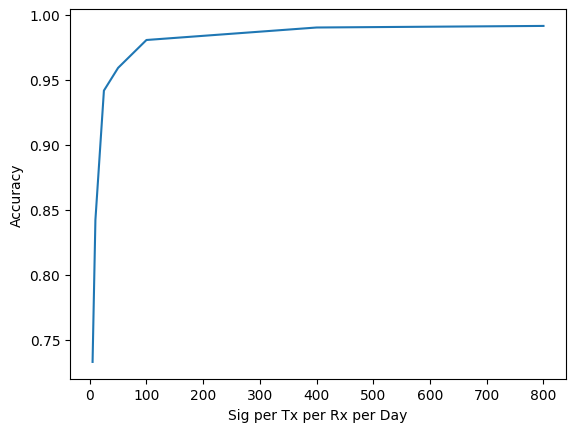

In [ ]:
plt.plot(np.array(sig_len_list),smTest_results_real)
plt.xlabel('Sig per Tx per Rx per Day')
plt.ylabel('Accuracy')
print(sig_len_list)
print(smTest_results_real)

[5, 10, 25, 50, 100, 400, 800]
[0.7328819632530212, 0.8422222137451172, 0.9418055415153503, 0.9593055844306946, 0.9807639122009277, 0.9903819561004639, 0.9915972352027893]


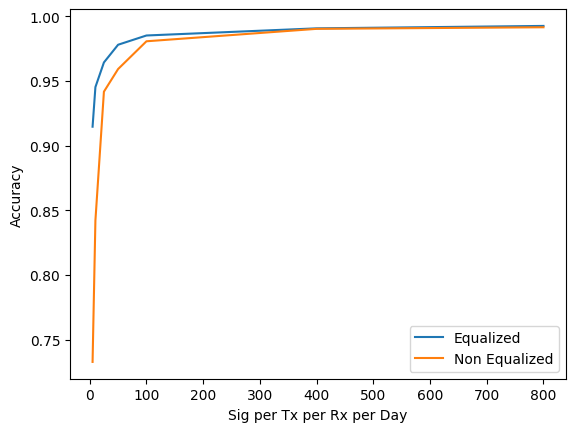

In [ ]:
res_eq= [0.9147222222222222, 0.9453472222222222, 0.9644097222222222, 0.9780902777777778, 0.9852430555555556, 0.9907638888888889, 0.9926388888888888]
plt.plot(np.array(sig_len_list),res_eq)
plt.plot(np.array(sig_len_list),smTest_results_real)
plt.xlabel('Sig per Tx per Rx per Day')
plt.ylabel('Accuracy')
print(sig_len_list)
print(smTest_results_real)
plt.legend(['Equalized','Non Equalized'])